# Wire routing for VHDE

This notebook shows a simple overview of how a wire routing algorithm could work.

    
## Usage
Use `shift`-`enter` to jump through the cells

# First setup

For the introduction of our routing algorithm we need to start with a simple setup.
In order to not repeat ourself too much, we will create three basic function for showing our images.

In [164]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# precision in digits used in any rounding operations
ndigits=3
EPS = 1*10**-ndigits

def plot_square(axes, xy, h, w):
    axes.add_patch( patches.Rectangle(xy, w,h))
    
def plot_lines(axes, list_of_pos, prop='r-o'):
    x_values, y_values = [], []
    for pos in list_of_pos:
        x_values += [pos[0]]
        y_values += [pos[1]]
        axes.plot(x_values, y_values, prop)

def create_plot():
    figure = plt.figure()
    plot = figure.add_subplot(111, aspect='equal')
    plot.grid(True)
    return plot

Let us first create a simple system with 2 blocks with one terminal per block that we want to connect as given in the first figure. The terminals are shown as red dots.

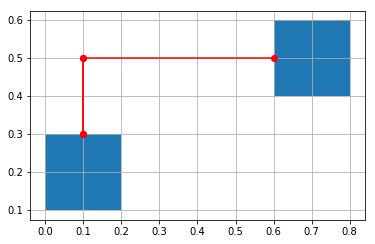

In [165]:
plot = create_plot()

plot_square( plot, (0.6, 0.4), h=0.2, w=0.2)
plot_square( plot, (0.0, 0.1), h=0.2, w=0.2)

plot_lines(plot, [(0.1, 0.3), (0.1, 0.5), (0.6, 0.5)])

## Block class

If we create a block class including the terminal coordinates we can handle them more easily later on.

In [166]:
class Block():
    def __init__(self, x, y, h, w, term_xy):
        self.x, self.y = x, y
        self.h, self.w = h, w
        self.term_xy = term_xy
    @property
    def xy(self):
        return (self.x, self.y)

Lets create the two blocks with each one terminal as was shown in the first image.

In [167]:
block1 = Block(x=0.0, y=0.1, h=0.2, w=0.2, term_xy=[(0.1, 0.35)])
block2 = Block(x=0.6, y=0.5, h=0.2, w=0.2, term_xy=[(0.55, 0.6)])

blocks = [block1, block2]

def plot_block(axes, block):
    axes.add_patch( patches.Rectangle(block.xy, block.w, block.h))
    for xy in block.term_xy:
        axes.plot(xy[0], xy[1], 'og')

## Creating a grid
Now let us create a [hanan grid](https://en.wikipedia.org/wiki/Hanan_grid) which is basically a grid where all points in the plot have a horizontal and vertical line through them.

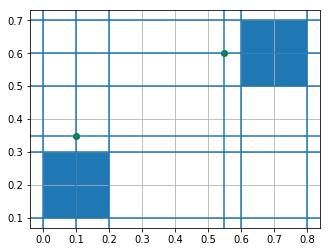

In [168]:
one_wire_plot = create_plot()

plot_block(one_wire_plot, block1)
plot_block(one_wire_plot, block2)

def calculate_all_hanan_grid_lines(blocks):
    h_lines, v_lines = [], []
    for block in blocks:
        for term_xy in block.term_xy:
            v_lines += [term_xy[0]]
            h_lines += [term_xy[1]]
            
        v_lines += [block.x]
        h_lines += [block.y]
        v_lines += [block.x + block.w]
        h_lines += [block.y + block.h]
    return h_lines, v_lines
            
h_lines, v_lines = calculate_all_hanan_grid_lines([block1, block2])

for h_line, v_line in zip(h_lines, v_lines):
    one_wire_plot.axhline(h_line)
    one_wire_plot.axvline(v_line)

## Calculate intersections
Let us now calculate all intersections of all grid lines, which are just all permutations of `v_lines` and `h_lines`. In the plot below you can see all gridpoints.

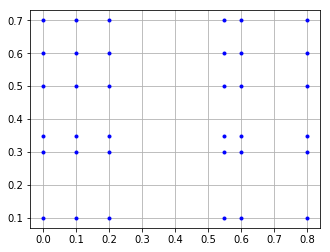

In [169]:
import itertools
all_grid_points = itertools.product(v_lines, h_lines)

x,y = zip(*all_grid_points)

grid_plot = create_plot()
grid_plot.plot(x, y, 'b.')

## Construct graph
From these gridpoints we can construct a graph which contains all intersections as nodes and all edges between these nodes, have the distance as weight. For creating the graph we iterate through all gridpoints from the bottom left corner to the top right corner and add them as node, we then connect them to the neighbouring node in the row below and the column to the left.

In [170]:
import networkx as nx

def create_graph_from_gridpoints(h_lines, v_lines, blocks):
    graph = nx.Graph()

    prev_x = None
    for x in sorted(v_lines):
        x = round(x, ndigits)
    
        prev_y = None
        for y in sorted(h_lines):
            y = round(y, ndigits)
            
            graph.add_node((x, y), pos=(x, y))
        
            # Add bottom to top edge
            if prev_y is not None:
                graph.add_edge((x, y), (x, prev_y), weight=abs(prev_y-y))
            # Add left to right edge
            if prev_x is not None:
                graph.add_edge((x, y), (prev_x, y), weight=abs(prev_x-x))
                
            prev_y = y
        prev_x = x
        
    return graph
        
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

We can plot the graph using `networkx`

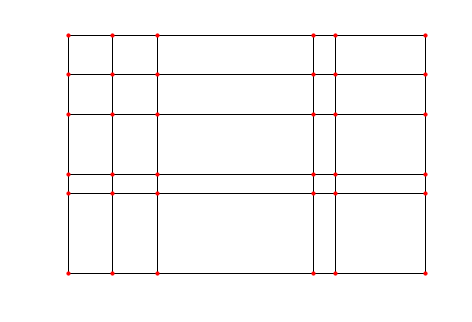

In [171]:
import warnings
warnings.filterwarnings('ignore')

def plot_graph(graph):
    pos=nx.get_node_attributes(graph, 'pos')
    # Might show deprecation: https://github.com/networkx/networkx/issues/2407
    nx.draw(graph, pos, node_size=10)
    
plot_graph(graph)

### Removing nodes inside blocks
Whoops, it is possible that there are edges and nodes within blocks, lets first remove any nodes within a block.
In order to do this we need a way to calculate if a given coordinate lies within any block.

Scan through all blocks to check if the given coordinates lie within a blocks bounding box.

In [172]:
def inside_blocks(x, y, blocks):
    for block in blocks: 
        if all([(x - EPS) > block.x, 
                (x + EPS) < (block.x + block.w),
                (y - EPS) > block.y,
                (y + EPS) < (block.y + block.h)]):
            return True
    return False

We need to adapt are graph creation function to not add a node or an edge when the coordinates within a block.

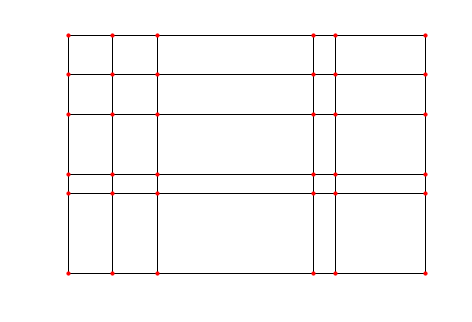

In [173]:
import networkx as nx

def create_graph_from_gridpoints(h_lines, v_lines, blocks):
    graph = nx.Graph()

    prev_x = None
    for x in sorted(v_lines):
        x = round(x, ndigits)
    
        prev_y = None
        for y in sorted(h_lines):
            y = round(y, ndigits)
            
            if not inside_blocks(x, y, blocks):
                graph.add_node((x, y), pos=(x, y))
        
                # Add bottom to top edge
                if prev_y is not None:
                    graph.add_edge((x, y), (x, prev_y), weight=abs(prev_y-y))
                # Add left to right edge
                if prev_x is not None:
                    graph.add_edge((x, y), (prev_x, y), weight=abs(prev_x-x))
            prev_y = y
        prev_x = x
        
    return graph
        
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

plot_graph(graph)

### Removing edges within blocks
Although we didn't add any nodes within a block, we still have edges that cross the interior of a block. We know that we create our graph from the bottom left to the top right corner, so if we have a function that can check if the previous coordinates were on either the left side or the bottom of a block, then we know we shouldn't add an edge to the graph on that position.

In [174]:
def on_edge_of_block(prevcoord, coord, blocks):
    ''' Check if the previous coord was on the edge of and between the corners '''
    
    x, y = coord[0], coord[1]
    px, py = prevcoord[0], prevcoord[1]
    
    on_left_of_block = False
    on_bottom_of_block = False
    
    for block in blocks:
            
        # If previous x was on left side of block
        if px is not None and abs(px - block.x) < EPS:
            # and it was between top and bottom of that block
            if y > block.y + EPS and y < (block.y + block.h - EPS):
                on_left_of_block = True
                return on_left_of_block, on_bottom_of_block
                
        # If previous y was on bottom side of block
        if py is not None and abs(py - block.y) < EPS:
            # and it was between left and right of that block
            if x > block.x + EPS and x < (block.x + block.w - EPS):
                on_bottom_of_block = True
                return on_left_of_block, on_bottom_of_block
        
    return on_left_of_block, on_bottom_of_block

We need to redefine our `create_graph` function so that it uses the edge checking function

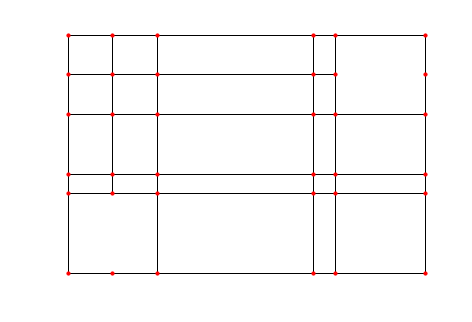

In [175]:
def create_graph_from_gridpoints(h_lines, v_lines, blocks):
    graph = nx.Graph()

    prev_x = None
    for x in sorted(v_lines):
        x = round(x, ndigits)
    
        prev_y = None
        for y in sorted(h_lines):
            y = round(y, ndigits)
            
            if not inside_blocks(x, y, blocks):
                graph.add_node((x, y), pos=(x, y))
                
                on_left_of_block, on_bottom_of_block = on_edge_of_block((prev_x, prev_y), (x, y), blocks)
        
                # Add bottom to top edge
                if not on_bottom_of_block and prev_y is not None:
                    graph.add_edge((x, y), (x, prev_y), weight=abs(prev_y-y))
                # Add left to right edge
                if not on_left_of_block and prev_x is not None:
                    graph.add_edge((x, y), (prev_x, y), weight=abs(prev_x-x))
            prev_y = y
        prev_x = x
        
    return graph
        
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

plot_graph(graph)

## Finding shortest path in grid
We now have a grid which contains only the valid edges and nodes.
We can use any pathfinding algorithm to calculate shortest path within this graph.
For now we will use an `networkx` library function. Next to that let's also create a function to plot the result of the routing.

In [176]:
def route_wire(graph, src, dest):
    return nx.shortest_path(graph,
                            source=src,                        
                            target=dest)

def plot_path(plot, path):
    x,y = zip(*path)
    plot.plot(x,y,'-')
    plot.plot(x,y,'.')

We can now route a path from the first terminal from `block1` to the first terminal of `block2`.

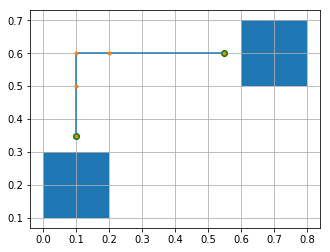

In [177]:
path = route_wire(graph, block1.term_xy[0], block2.term_xy[0])

routed_plot = create_plot()

plot_block(routed_plot, block1)
plot_block(routed_plot, block2)

plot_path(routed_plot, path)

Lets create a function for plotting all block and paths

In [178]:
def plot_blocks_and_paths(blocks, paths):
    plot = create_plot()

    for block in blocks:
        plot_block(plot, block)
    for path in paths:
        plot_path(plot, path)

# Adding an additional block
This is a trivial example, lets add another block (`block3`) that is in the way of our current block and some extra terminals and wires.

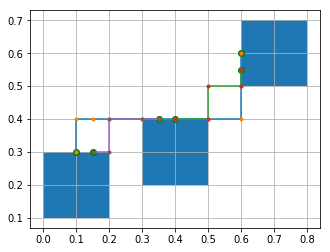

In [179]:
block1 = Block(x=0.0, y=0.1, h=0.2, w=0.2, term_xy=[(0.1, 0.30), (0.15, 0.30)])
block2 = Block(x=0.6, y=0.5, h=0.2, w=0.2, term_xy=[(0.6, 0.6), (0.6, 0.55)])
block3 = Block(x=0.3, y=0.2, h=0.2, w=0.2, term_xy=[(0.4, 0.4), (0.35, 0.4)])

blocks = [block1, block2, block3]

h_lines, v_lines = calculate_all_hanan_grid_lines(blocks)
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

path1 = route_wire(graph, block1.term_xy[0], block2.term_xy[0])
path2 = route_wire(graph, block2.term_xy[1], block3.term_xy[0])
path3 = route_wire(graph, block1.term_xy[1], block3.term_xy[1])
        
plot_blocks_and_paths(blocks, [path1, path2, path3])

## Fix overlapping paths
Yikes, paths overlap and follow edges of the blocks. Let us first fix the overlapping. Once a path is routed we need to block the path in the graph to prevent other routes to go through the same path. We can adapt the graph through a simple function which just removes the edges of the route altogether.

In [180]:
def block_path_in_graph(graph, path):  
    prev_point = None
    for point in path:
        if prev_point:
            graph.remove_edge(prev_point, point)
        prev_point = point

And use that function through an adapted `route_wire` implementation which directly blocks the routed path.

In [181]:
def route_wire(graph, src, dest):
    path = nx.shortest_path(graph, source=src, target=dest)
    block_path_in_graph(graph, path)
    return path

Lets try the same routing again

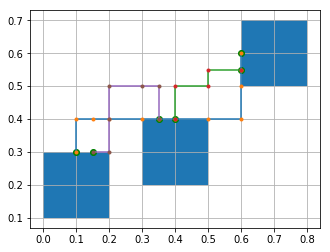

In [182]:
h_lines, v_lines = calculate_all_hanan_grid_lines(blocks)
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

path1 = route_wire(graph, block1.term_xy[0], block2.term_xy[0])
path2 = route_wire(graph, block2.term_xy[1], block3.term_xy[0])
path3 = route_wire(graph, block1.term_xy[1], block3.term_xy[1])

plot_blocks_and_paths(blocks, [path1, path2, path3])

## Don't route alongside block edges

To make the routing better, the next step is to remove the edges on the sides of the blocks to improve the routing.
An edge is on the side of a block if both nodes that are connected are on the same block. 

Following is a naive first implementation

In [183]:
def edge_is_on_block_edge(node1, node2, blocks):
    ''' Check if both nodes lie on any edge of block '''
    
    x1, y1 = node1[0], node1[1]
    x2, y2 = node2[0], node2[1]
    
    both_nodes_on_lr_edges = False
    both_nodes_on_tb_edges = False
    
    for block in blocks:
        for x,y in zip([x1, x2], [y1, y2]):
            
            # If both x coords are on either left or right side of block    
            if abs(x - block.x) < EPS or \
                abs(x - block.x - block.w) < EPS:

                # and it was between top and bottom of that block
                if y >= block.y and y <= block.y + block.h:
                    both_nodes_on_lr_edges = True
                else:
                    both_nodes_on_lr_edges = False
                    break
            else:
                both_nodes_on_lr_edges = False
                break
                    
        if both_nodes_on_lr_edges:
            return True
                    
        for x,y in zip([x1, x2], [y1, y2]):
            # If both y coords are on either top or bottom side of block
            if abs(y - block.y) < EPS or \
                abs(y - block.y - block.h) < EPS:

                # and it was between left and right of that block
                if x >= block.x and x <= block.x + block.w:
                    both_nodes_on_tb_edges = True
                else:
                    both_nodes_on_tb_edges = False
                    break
            else:
                both_nodes_on_tb_edges = False
                break

        if both_nodes_on_tb_edges:
            return True
        
    return False

We need to adapt our graph creation function to use this. 
Since this function tells if edge goes from block edge to block edge on same block, the need for checking if an edge is on the left or bottom side of any block has disappeared. We only need to add an edge if from bottom-to-top or left-to-right if the edge is not on the edges of an block.

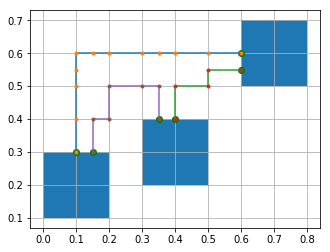

In [184]:
def create_graph_from_gridpoints(h_lines, v_lines, blocks):
    graph = nx.Graph()

    prev_x = None
    node_count = 0
    for x in sorted(v_lines):
        x = round(x, ndigits)
        if x == prev_x: continue
    
        prev_y = None
        for y in sorted(h_lines):
            y = round(y, ndigits)
            if y == prev_y: continue
            
            if not inside_blocks(x, y, blocks):
                graph.add_node((x, y), pos=(x, y))
                
                node_count += 1
                                
                # Add bottom to top edge
                if prev_y is not None and not edge_is_on_block_edge((x,y), (x, prev_y), blocks):
                    graph.add_edge((x, y), (x, prev_y), weight=abs(prev_y-y))
                    
                # Add left to right edge
                if prev_x is not None and not edge_is_on_block_edge((x,y), (prev_x, y), blocks):
                    graph.add_edge((x, y), (prev_x, y), weight=abs(prev_x-x))

                prev_y = y
        prev_x = x
        
    return graph

h_lines, v_lines = calculate_all_hanan_grid_lines(blocks)
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)
pos=nx.get_node_attributes(graph,'pos')

path1 = route_wire(graph, block1.term_xy[0], block2.term_xy[0])
path2 = route_wire(graph, block2.term_xy[1], block3.term_xy[0])
path3 = route_wire(graph, block1.term_xy[1], block3.term_xy[1])

plot_blocks_and_paths(blocks, [path1, path2, path3])

This works but a problem is hidden in the implementation. Edges are added for _ghost_ nodes, implicitly adding the nodes in the process. To solve this we should add an edge to the first existing node to the left. This means the `prev_x` should be dependent on the `y` and we can use dictionary for this.

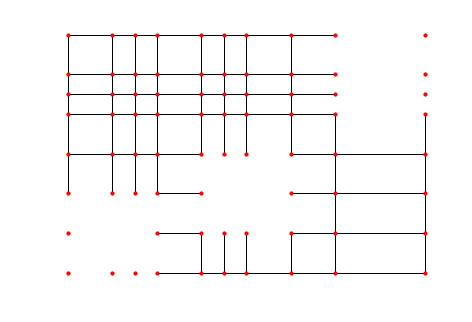

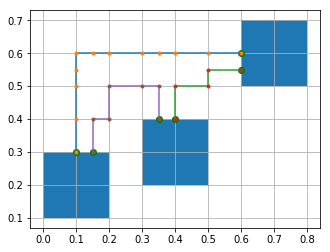

In [185]:

def create_graph_from_gridpoints(h_lines, v_lines, blocks):
    graph = nx.Graph()

    prev_x = dict(zip([round(y, ndigits) for y in h_lines], [None] * len(h_lines)))

    node_count = 0
    for x in sorted(v_lines):
        x = round(x, ndigits)
        if x == prev_x: continue
    
        prev_y = None
        for y in sorted(h_lines):
            y = round(y, ndigits)
            if y == prev_y: continue
            
            if not inside_blocks(x, y, blocks):
                
                px = prev_x[y]
                
                graph.add_node((x, y), pos=(x, y))
                prev_x[y] = x
                                
                # Add bottom to top edge
                if prev_y is not None and not edge_is_on_block_edge((x,y), (x, prev_y), blocks):
                    graph.add_edge((x, y), (x, prev_y), weight=abs(prev_y-y))
                    
                # Add left to right edge
                if px is not None and not edge_is_on_block_edge((x,y), (px, y), blocks):
                    graph.add_edge((x, y), (px, y), weight=abs(px-x))

                prev_y = y
        
    return graph

h_lines, v_lines = calculate_all_hanan_grid_lines(blocks)
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

plot_graph(graph)

path1 = route_wire(graph, block1.term_xy[0], block2.term_xy[0])
path2 = route_wire(graph, block2.term_xy[1], block3.term_xy[0])
path3 = route_wire(graph, block1.term_xy[1], block3.term_xy[1])

plot_blocks_and_paths(blocks, [path1, path2, path3])

This already looks better. One obvious observation is that the wires do not choose the route with the least amount of corners.
Let us investigate this further

## Reduce amount of corners

The amount of corners is determined by the shortest path algorithm use in `route_wire` function.

> To be extended

# Wire routing order dependency
Lets see how it handles a different order of wire routing with crossing lines. We will add a new terminal to `block3` and `block2` which forces a crossing. If we add a routing in two different orders and plot them both we can see there is a difference.

In [186]:
block1 = Block(x=0.0, y=0.1, h=0.2, w=0.2, term_xy=[(0.1, 0.30), (0.15, 0.30)])
block2 = Block(x=0.6, y=0.5, h=0.2, w=0.2, term_xy=[(0.6, 0.6), (0.6, 0.55), (0.6, 0.65)])
block3 = Block(x=0.3, y=0.2, h=0.2, w=0.2, term_xy=[(0.4, 0.4), (0.35, 0.4), (0.45, 0.4)])

blocks = [block1, block2, block3]

h_lines, v_lines = calculate_all_hanan_grid_lines(blocks)

This is the graph we have seen before with a new wire to be routed added as last item:

In [187]:
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)
paths_order1  = [route_wire(graph, block1.term_xy[0], block2.term_xy[0])]
paths_order1 += [route_wire(graph, block2.term_xy[1], block3.term_xy[0])]
paths_order1 += [route_wire(graph, block1.term_xy[1], block3.term_xy[1])]
# Here is the new path
paths_order1 += [route_wire(graph, block2.term_xy[2], block3.term_xy[2])]

Here we have exactly the same blocks and wires but routed in a different order

In [188]:
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)
paths_order2  = [route_wire(graph, block1.term_xy[0], block2.term_xy[0])]
# Here is the new path
paths_order2 += [route_wire(graph, block2.term_xy[2], block3.term_xy[2])]
paths_order2 += [route_wire(graph, block2.term_xy[1], block3.term_xy[0])]
paths_order2 += [route_wire(graph, block1.term_xy[1], block3.term_xy[1])]

We can now plot both routed situations and clearly see that the order of routing influences the paths created

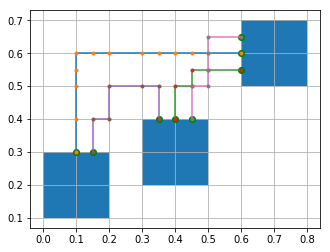

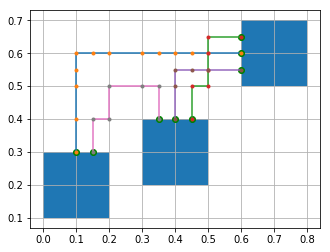

In [189]:
plot_blocks_and_paths(blocks, paths_order1)
plot_blocks_and_paths(blocks, paths_order2)

## Deciding the order of routing

We can make a decision on the order to get better results:

> To be extended
> Possible heuristics that can be used for ordering:
> * Block distance
> * Number of terminals of a block

# Unroutable paths

If we move our `block2` from previous example down so that it is covered by `block3` we get the following image.

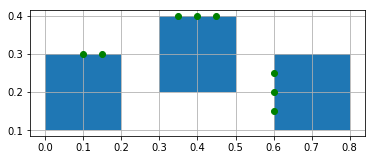

In [190]:
block1 = Block(x=0.0, y=0.1, h=0.2, w=0.2, term_xy=[(0.1, 0.30), (0.15, 0.30)])
block2 = Block(x=0.6, y=0.1, h=0.2, w=0.2, term_xy=[(0.6, 0.2), (0.6, 0.15), (0.6, 0.25)])
block3 = Block(x=0.3, y=0.2, h=0.2, w=0.2, term_xy=[(0.4, 0.4), (0.35, 0.4), (0.45, 0.4)])

blocks = [block1, block2, block3]

plot = create_plot()
for block in blocks:
    plot_block(plot, block)

If we create our gridlines and graph for these blocks we get the following graph:

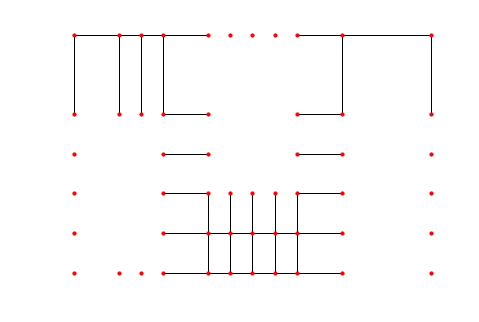

In [191]:
h_lines, v_lines = calculate_all_hanan_grid_lines(blocks)
graph = create_graph_from_gridpoints(h_lines, v_lines, blocks)

plot_graph(graph)

It can be seen that the graph will never have enough edges for creating paths from-to all terminals. We need a way to add additional gridlines.

# Todo's

- Improve code
- Check non-trivial routing
- Add additional gridlines in between blocks?
- Improve code:
   - For checking if inside or on edges of blocks, blocks are iterated a lot of times, combine calculations
- Improve shortest path calculation to favor straight lines (reduce corners) 